# captcha-4-letter

**Captcha Classification using DNN.** 

Dataset used : [captcha-4-letter](https://www.kaggle.com/genesis16/captcha-4-letter).

Our modified dataset :  [Cleaned Data hosted from Github](https://github.com/Jimut123/MLCP/raw/master/data/captcha_4_letter.tar.gz)

This notebook is the modified implementation of this kernel in Kaggle [captcha-4-letter](https://www.kaggle.com/aakashnain/cracking-captcha).


In [3]:
# for tensorboard => used to visualize graph, use Runtime-> Interrupt execution to stop this after first run
! python -m tensorboard.main --logdir=/path/to/logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [0]:
# I don't like warning messages too much
import warnings
warnings.filterwarnings("ignore")

In [1]:
%tensorflow_version 1.x
import os
import gc
import cv2
import glob
import h5py
import shutil
import itertools
import random as rn
from datetime import datetime

import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from keras import callbacks
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from keras.layers import Input, Flatten, BatchNormalization, Lambda
from keras.layers import CuDNNGRU, CuDNNLSTM, Bidirectional, LSTM, GRU
from keras.layers import Add, Concatenate, Reshape
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model  #plotting the model structure

from keras import backend as K
import tensorflow as tf


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

# load tensorboard for visualizations
%load_ext tensorboard 


TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [14]:
!wget "https://github.com/Jimut123/MLCP/raw/master/data/captcha_4_letter.tar.gz" -O captcha_4_letter.tar.gz

--2020-03-31 19:18:34--  https://github.com/Jimut123/MLCP/raw/master/data/captcha_4_letter.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jimut123/MLCP/master/data/captcha_4_letter.tar.gz [following]
--2020-03-31 19:18:34--  https://raw.githubusercontent.com/Jimut123/MLCP/master/data/captcha_4_letter.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21710322 (21M) [application/octet-stream]
Saving to: ‘captcha_4_letter.tar.gz’

captcha_4_letter.ta 100%[===================>]  20.70M  51.4MB/s    in 0.4s    

2020-03-31 19:18:35 (51.4 MB/s) - ‘captcha_4_letter.tar.gz’ saved [21710322/21710

In [15]:
!tar -xvf captcha_4_letter.tar.gz > /dev/null
! echo "Untaring... done..."

tar: captcha_4_letter/captcha: implausibly old time stamp 1969-12-31 18:30:00
Untaring... done...


In [0]:
!cd captcha_4_letter

In [3]:
!ls

captcha_4_letter  captcha_4_letter.tar.gz  sample_data


In [4]:
# print the first 10 contents of the train directory
print(os.listdir("captcha_4_letter")[:10])
png_files = glob.glob('captcha_4_letter/*.png')
png_files[:10]

['R8UF.png', 'RBB5.png', 'FFQ4.png', 'BK3C.png', 'QPNL.png', 'AFU2.png', '4FBK.png', '584T.png', '94DH.png', 'U5L3.png']


['captcha_4_letter/R8UF.png',
 'captcha_4_letter/RBB5.png',
 'captcha_4_letter/FFQ4.png',
 'captcha_4_letter/BK3C.png',
 'captcha_4_letter/QPNL.png',
 'captcha_4_letter/AFU2.png',
 'captcha_4_letter/4FBK.png',
 'captcha_4_letter/584T.png',
 'captcha_4_letter/94DH.png',
 'captcha_4_letter/U5L3.png']

In [0]:
## I said it earlier as well, do everything you can to make your results reproducible. It matters!!

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# set the seed for random number generator
rn.seed(seed)

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(seed)

# We will be using CuDNN implementation of RNNs which already is non-reproducible
# So I am trying to get results as close as possible on different runs
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [6]:
# path to the data directory
data_dir = Path("captcha_4_letter")

# getting list of all images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))

Number of images found:  9955


Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)


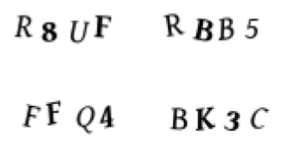

In [7]:
# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

f,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = imread(sample_images[i])
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

Before that we need to know:
* What all `unique` alphanumeric characters are present in the images?
* What is the maximum length of any captcha? (This is needed to encode captcha to vectors)

Let's find out.

In [8]:
# make a set of all unique characters. Letter is a wrong
# word to use here but I am gonna use it for now.
letters = set()

# A list to store the max length for each catcha
lengths = []

# Iterate over each image. The name of the image is the 
# text ccontained in it. 
for image in images:
    image_name = str(image.name).split(".")[0]
    lengths.append(len(image_name))
    for ch in image_name:
        letters.add(ch)

# Sort the letters        
letters = sorted(letters)
print("Number of unqiue letters in the whole dataset: ", len(letters))
print("Maximum length of any captcha: ", max(Counter(lengths).keys()))
print("\nAll letters to be considered: ")
print(letters)

Number of unqiue letters in the whole dataset:  32
Maximum length of any captcha:  4

All letters to be considered: 
['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [9]:
dataset = []

for image in images:
    image_path = str(image)
    label = str(image.name).split(".")[0]
    dataset.append((image_path, label))

dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)
dataset = dataset.sample(frac=1.).reset_index(drop=True)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head(10)

Total number of samples in the dataset:  9955


,img_path,label
0,captcha_4_letter/Z7R2.png,Z7R2
1,captcha_4_letter/LW6F.png,LW6F
2,captcha_4_letter/PPUQ.png,PPUQ
3,captcha_4_letter/BD7C.png,BD7C
4,captcha_4_letter/RJ96.png,RJ96
5,captcha_4_letter/RT24.png,RT24
6,captcha_4_letter/JZWX.png,JZWX
7,captcha_4_letter/3NNB.png,3NNB
8,captcha_4_letter/UHK5.png,UHK5
9,captcha_4_letter/FRRE.png,FRRE


In [10]:
# split into train and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  8959
Number of validation samples:  996


In [0]:
# function to create labels from text
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

# function to convert labels back to texts
def labels_to_text(label):
    return ''.join(list(map(lambda x: letters[int(x)], label)))

# sanity-check for letters
def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

In [0]:
def build_data(df, resize=True, img_height=24, img_width=72):
    """This function reads samples from a dataframe and store
    the image values and labels in two separate arrays.
    
    Args:
        df        : dataframe from which we want to read the data
        resize    : whether to resize images or not
        img_weidth: width of images to be considered
        img_height: height of images to be considered
        
    Returns:
        images    : numpy array of images
        labels    : numpy array of encoded labels
    """
    n = len(df)
    images = np.zeros((n, img_height, img_width), dtype=np.float32)
    labels = [0]*n
    for i in range(n):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize:
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # only add to if all the charaters are valid
        if is_valid_str(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [13]:
# Building training data
training_images, training_labels = build_data(training_data)
print("Number of training images: ", training_images.shape)
print("Number of training labels: ", training_labels.shape)

Number of training images:  (8959, 24, 72)
Number of training labels:  (8959,)


In [14]:
# Building validation data
validation_images, validation_labels = build_data(validation_data)
print("Number of validation images: ", validation_images.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of validation images:  (996, 24, 72)
Number of validation labels:  (996,)


In [15]:
validation_images[0].shape

(24, 72)

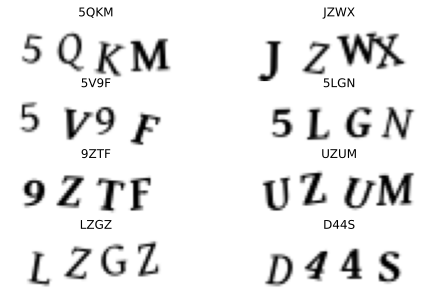

In [16]:
# Check some samples again
f,ax = plt.subplots(4,2, figsize=(8,5))
for i in range(4):
    ax[i//2, i%2].imshow(training_images[i], cmap='gray')
    ax[i//2, i%2].set_title(training_labels[i])
    ax[i//2, i%2].axis('off')

for i in range(4, 8):
    ax[i//2, i%2].imshow(validation_images[i], cmap='gray')
    ax[i//2, i%2].set_title(validation_labels[i])
    ax[i//2, i%2].axis('off')
    
plt.show()

In [0]:
def data_generator(df, 
                   batch_size, 
                   img_width, 
                   img_height, 
                   downsample_factor, 
                   max_text_len, 
                   is_validation_data=False):
    """This is a data generator which yields batches 
    of (image, label) pairs.
    
    Args:
        df                : training or validation dataframe
        batch_size        : batch size ti be used during training
        img_width         : width of images to be considered  
        img_height        : height of images to be considered
        downsample_factor : by what factor the CNN has downsampled the images
        max_text_len      : maximum length of the text in your data
        is_validation_data: is the data being considered a validation data?
        
    Returns:
        inputs: numpy array containg inputs that are required for the final model
        outputs: a dummy array of zeros 
    """
    n = len(df)
    indices = np.arange(n)
    np.random.shuffle(indices)
    nb_batches = int(np.ceil(n/batch_size))
    
    if not is_validation_data:
        images, texts = training_images, training_labels
    else:
        images, texts = validation_images, validation_labels
    
    batch_images = np.ones((batch_size, img_width, img_height, 1), dtype=np.float32)
    batch_labels = np.ones((batch_size, max_text_len), dtype=np.float32)
    input_length = np.ones((batch_size, 1), dtype=np.int64) * \
                                            (img_width // downsample_factor - 2)
    label_length = np.zeros((batch_size, 1), dtype=np.int64)
    
    while True:
        for i in range(nb_batches):
            idx_to_consider = indices[i*batch_size:(i+1)*batch_size]
            
            for j, idx in enumerate(idx_to_consider):
                img = images[idx].T
                img = np.expand_dims(img, axis=-1)
                text = texts[idx]
                
                if is_valid_str(text):
                    label = text_to_labels(texts[idx])
                    batch_images[j] = img
                    batch_labels[j] = label
                    label_length[j] = len(text)

            inputs = {
            'input_data': batch_images,
            'input_label': batch_labels,
            'input_length': input_length,
            'label_length': label_length,
            }
            
            outputs = {'ctc_loss': np.zeros([batch_size], dtype=np.float32)}
            yield inputs, outputs

In [0]:
# batch size to be used for training
batch_size = 32

# image dimensions
img_width=72
img_height=24 

# by what factor the image has been downsampled by the CNN part?
downsample_factor=4

# maximum length of any text in the data
max_text_len=4

In [0]:
# Get a generator object for the training data
train_data_generator = data_generator(training_data, 
                                      batch_size=batch_size, 
                                      img_width=img_width, 
                                      img_height=img_height, 
                                      downsample_factor=downsample_factor, 
                                      max_text_len=max_text_len, 
                                      is_validation_data=False)

# Get a generator object for the validation data 
valid_data_generator = data_generator(validation_data, 
                                      batch_size=batch_size, 
                                      img_width=img_width, 
                                      img_height=img_height, 
                                      downsample_factor=downsample_factor, 
                                      max_text_len=max_text_len, 
                                      is_validation_data=True)

In [0]:
# A handy-dandy function for checking the generator output
# always sanity-check your data before passing it to the model
def visualize_data_gen_output(data_gen, samples_to_visualize=2):
    for i, (inp, out) in enumerate(data_gen):
        print('Text generator output (data which will be fed into the neutral network):')
        print('1)the_input (image)')
        img = (inp['input_data'][i, :, :, 0]*255).astype(np.uint8)
        plt.imshow(img.T, cmap='gray')
        plt.show()
        print(f"2) the_labels(captcha) {labels_to_text(inp['input_label'][i])} is encoded as {list(map(int, inp['input_label'][i]))}") 
        print(f"3) input_length (width of image that is fed to the network after CNN): {inp['input_length'][i][0]} == (72/4 - 2)")
        print(f"4) label_length (length of captcha): {inp['label_length'][i][0]}")
        print(" ")
        if i==samples_to_visualize:
            break

Text generator output (data which will be fed into the neutral network):
1)the_input (image)


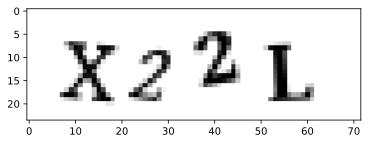

2) the_labels(captcha) X22L is encoded as [29, 0, 0, 18]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


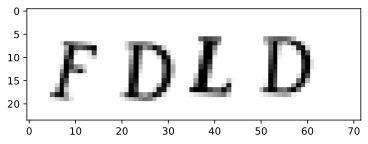

2) the_labels(captcha) FDLD is encoded as [13, 11, 18, 11]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


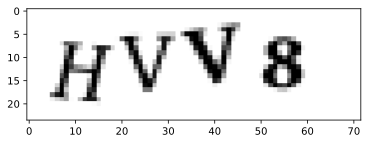

2) the_labels(captcha) HVV8 is encoded as [15, 27, 27, 6]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 


In [21]:
visualize_data_gen_output(train_data_generator)

Text generator output (data which will be fed into the neutral network):
1)the_input (image)


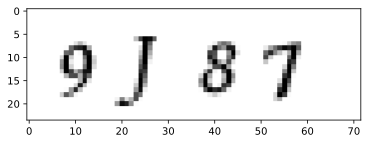

2) the_labels(captcha) 9J87 is encoded as [7, 16, 6, 5]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


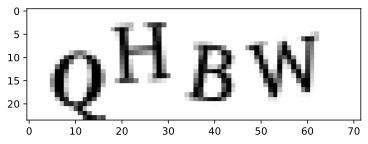

2) the_labels(captcha) QHBW is encoded as [22, 15, 9, 28]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


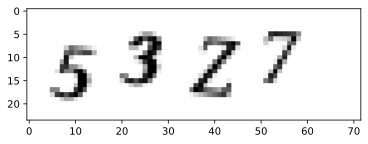

2) the_labels(captcha) 53Z7 is encoded as [3, 1, 31, 5]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 


In [22]:
visualize_data_gen_output(valid_data_generator)

In [0]:
# We will be using this loss function as the output
# The loss function in model.compile(..) will be a dummy one
# This is different from a normal scenario where you pass an actual 
# loss function when you compile the model
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [0]:
def build_model():
    # Inputs to the model
    input_img = Input(shape=(img_width, img_height, 1), name='input_data', dtype='float32')
    labels = Input(name='input_label', shape=[max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    # Convolution part for feaure extraction
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    # Reshape the features for passing to RNN
    # We have used two max pool with pool size and strides of 2. Hence, downsampled is 4x smaller
    # Also, the number of filters in the last layer is 64.
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = Reshape(target_shape=new_shape, name='reshape')(x)
    x = Dense(64, activation='relu', name='dense1')(x)
    
    # RNNs
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True,  name='lstm_1'), name='bi_1')(x)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True,  name='lstm_2'), name='bi_2')(x)
    
    # final part
    x = Dense(len(letters)+1, activation='softmax', name='dense2', kernel_initializer='he_normal')(x)
    
    # Get the CTC loss and represent it in a layer
    output = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([x, labels, input_length, label_length])
    
    # define the final model
    model = Model([input_img, labels, input_length, label_length], output, name='ocr_model_v1')
    
    # optimizer
    sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    # this is the reason we have this ctc_loss array of zeros in our generator
    model.compile(loss={'ctc_loss': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    return model

In [25]:
model = build_model()
model.summary()





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         (None, 72, 24, 1)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 72, 24, 32)   320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 36, 12, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 36, 12, 64)   18496       pool1[0][0]          

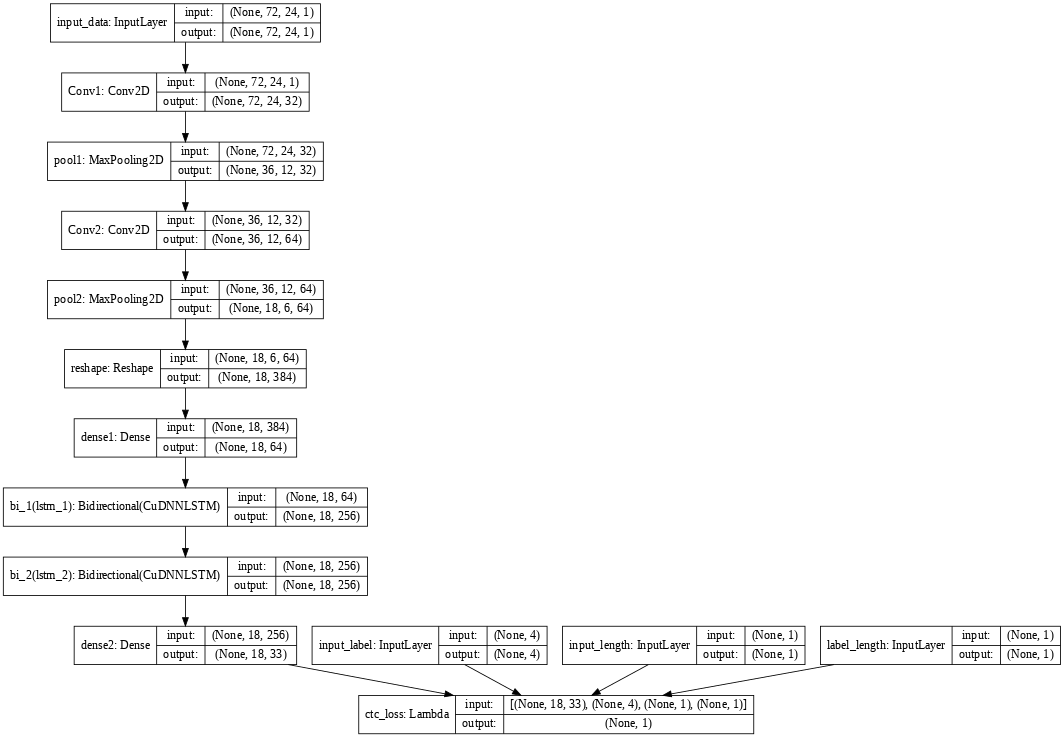

In [26]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [0]:
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
# things required for starting the training 
nb_epochs = 50
nb_train_steps = training_data.shape[0] // batch_size
nb_validation_steps = validation_data.shape[0] // batch_size
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ckpt = ModelCheckpoint(filepath='ocr_v2.h5', save_best_only=True, monitor='val_loss')

In [29]:
# Train the model
# perform rm -rf logs in case this stops early, or remove the model
history = model.fit_generator(train_data_generator, 
                    epochs=nb_epochs, 
                    steps_per_epoch=nb_train_steps, 
                    validation_data=valid_data_generator, 
                    validation_steps=nb_validation_steps,
                    callbacks=[es, ckpt,tensorboard_callback])



Epoch 1/50




  8/279 [..............................] - ETA: 7:47 - loss: 35.1005 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


279/279 [==============================] - 21s 77ms/step - loss: 15.7566 - val_loss: 14.8079
Epoch 2/50
279/279 [==============================] - 8s 27ms/step - loss: 14.7412 - val_loss: 14.7166
Epoch 3/50
279/279 [==============================] - 8s 28ms/step - loss: 14.6782 - val_loss: 14.6741
Epoch 4/50
279/279 [==============================] - 8s 29ms/step - loss: 14.6610 - val_loss: 14.6551
Epoch 5/50
279/279 [==============================] - 7s 27ms/step - loss: 14.6405 - val_loss: 14.6813
Epoch 6/50
279/279 [==============================] - 8s 27ms/step - loss: 14.5609 - val_loss: 14.4287
Epoch 7/50
279/279 [==============================] - 8s 27ms/step - loss: 14.2701 - val_loss: 14.1879
Epoch 8/50
279/279 [==============================] - 7s 27ms/step - loss: 14.1296 - val_loss: 14.1986
Epoch 9/50
279/279 [==============================] - 7s 27ms/step - loss: 13.9949 - val_loss: 13.9506
Epoch 10/50
279/279 [==============================] - 8s 27ms/step - loss: 13.7608

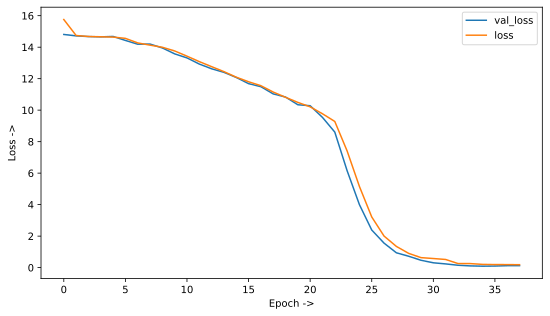

In [63]:
# plt.figure(figsize=(10,6))
# legend_acc = []
# for item in history.history.keys():
#   if item.split('_')[-1:] == ['acc']:
#     #print("Accuracy = ",item)
#     legend_acc.append(item)
#     plt.plot(history.history[item])
# plt.ylabel('Accuracy ->')
# plt.xlabel('Epoch ->')
# plt.legend(legend_acc, loc='upper left')
# plt.show()

plt.figure(figsize=(9,5))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [0]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, 2:]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = K.get_value(K.ctc_decode(pred, 
                                   input_length=input_len,
                                   greedy=True)[0][0])
    
    # Iterate over the results and get back the text
    texts = []
    for res in results:
        outstr = ''
        for c in res:
            if c < len(letters):
                outstr += letters[c]
        texts.append(outstr)
    
    # return final text results
    return texts

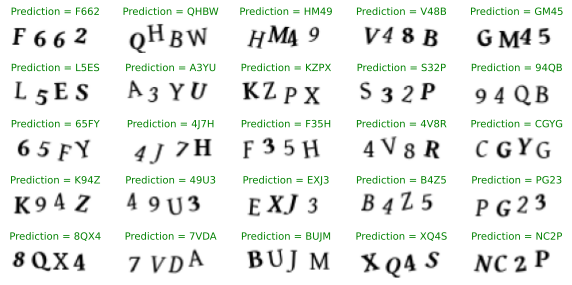

In [62]:
# total_img = 36
# num_pr = 6 # number per row

# counter = 1
# plt.figure(figsize=(30,15))
# plt.axis('off')
# for item in png_files[:total_img]:
#   image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
#   pred = predict(item)
#   #print(pred)
#   image_bckup = image.copy()
#   plt.subplot(num_pr, num_pr, counter)
#   #print("item => ",item)
#   #print("item => ",str(item.split('_')[1]).split('/')[1])
#   if str(item.split('_')[1]).split('/')[1] == str(pred):
#     plt.title("Prediction = {}".format(pred),fontsize=20).set_color('green')
#   else:
#     plt.title("Prediction = {}".format(pred),fontsize=20).set_color('red')
#   plt.axis('off')
#   plt.imshow(image_bckup, cmap=plt.get_cmap('gray'))
#   counter += 1
#   #break



# Get the input output layer and define a Keras function
# It is similar to getting layers in tensorflow and 
# passing the information to the session.
output_func = K.function([model.get_layer(name='input_data').input],
                        [model.get_layer(name='dense2').output])


#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = output_func([X_data])[0]
    pred_texts = decode_batch_predictions(preds)
    total_img = len(labels)
    num_pr = 5 # number per row
    counter = 1
    plt.figure(figsize=(10,5))
    #print(bs)
    orig_texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        orig_texts.append(text)
        
    for i in range(bs):
        plt.subplot(num_pr, num_pr, counter)
        if orig_texts[i] == pred_texts[i]:
          plt.title("Prediction = {}".format(pred_texts[i]),fontsize=10).set_color('green')
        else:
          plt.title("Prediction = {}".format(pred_texts[i]),fontsize=10).set_color('red')
        plt.axis('off')
        item = "captcha_4_letter/"+orig_texts[i]+".png"
        image_backup = cv2.imread(item, cv2.IMREAD_UNCHANGED)
        plt.imshow(image_backup, cmap=plt.get_cmap('gray'))
        counter += 1
        if counter%26 == 0:
          break
        #print(f'GT: {orig_texts[i]} \t Predicted: {pred_texts[i]}')

    break
plt.show()

In [35]:
# Get the input output layer and define a Keras function
# It is similar to getting layers in tensorflow and 
# passing the information to the session.
output_func = K.function([model.get_layer(name='input_data').input],
                        [model.get_layer(name='dense2').output])


#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = output_func([X_data])[0]
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'GT: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

GT: 9U84 	 Predicted: 9U84
GT: DBPR 	 Predicted: DBPR
GT: 9N8J 	 Predicted: 9N8J
GT: K2NU 	 Predicted: K2NU
GT: RE6M 	 Predicted: RE6M
GT: B4G2 	 Predicted: B4G2
GT: M9ZR 	 Predicted: M9ZR
GT: YQPX 	 Predicted: YQPX
GT: 6HS4 	 Predicted: 6HS4
GT: M5BK 	 Predicted: M5BK
GT: NZR9 	 Predicted: NZR9
GT: TM2C 	 Predicted: TM2C
GT: XHN9 	 Predicted: XHN9
GT: STUN 	 Predicted: STUN
GT: WBKH 	 Predicted: WBKH
GT: DFCA 	 Predicted: DFCA
GT: KRSM 	 Predicted: KRSM
GT: 2Z5T 	 Predicted: 2Z5T
GT: NQ23 	 Predicted: NQ23
GT: 934L 	 Predicted: 934L
GT: 8WCT 	 Predicted: 8WCT
GT: MPYT 	 Predicted: MPYT
GT: PQ9E 	 Predicted: PQ9E
GT: QLQA 	 Predicted: QLQA
GT: S2BF 	 Predicted: S2BF
GT: A6T9 	 Predicted: A6T9
GT: ZDGA 	 Predicted: ZDGA
GT: R3LG 	 Predicted: R3LG
GT: SJW3 	 Predicted: SJW3
GT: UFB7 	 Predicted: UFB7
GT: ZY6G 	 Predicted: ZY6G
GT: T4X5 	 Predicted: T4X5


In [0]:
# To download less than 50 MB file from Colab
# https://stackoverflow.com/questions/48924165/google-colaboratory-weight-download-export-saved-models
model.save('model_captcha_4_letter_v1.h5')
from google.colab import files
files.download("model_captcha_4_letter_v1.h5")

In [0]:
# !ls
# !rm model.h5
# !rm ocr_v2.h5

In [0]:
# https://www.tensorflow.org/tensorboard/graphs
%tensorboard --logdir logs

In [54]:
import os
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from keras import layers        # functional 
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import numpy as np
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model  #plotting the model structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt

import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = png_files[2]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
#img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x[np.newaxis,:]#x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(k)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    plt.figure(figsize=(50, 15))
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
     
      # We'll tile each filter into this big horizontal grid
      plt.subplot(1, n_features, count)
      plt.imshow(x, cmap='viridis')
      plt.axis("off")
      count += 1
      #display_grid[:, i * size : (i + 1) * size2] = x
    plt.xticks([])
    
    plt.yticks([])
    plt.show()

NameError: ignored

In [0]:
x.shape

In [0]:
k = validation_images[0].copy()
k = k[np.newaxis,:,]
k.shape